# Control Co-Design of Power Take-off Systems for Wave Energy Converters using WecOptTool
Carlos A. **Michelén Ströfer**, Daniel T. **Gaebele**, Ryan G. **Coe**, and Giorgio **Bacelli** (Member IEEE)

IEEE Transactions on Sustainable Energy, [MONTH] 2023

[DOI]

In [1]:
import autograd.numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import capytaine as cpy
# import mhkit.wave.resource as mhkit
# from mhkit.wave.io import ndbc
import pandas as pd
import string
from sklearn.cluster import KMeans
from datetime import datetime
from scipy.optimize import brute

import wecopttool as wot

In [2]:
wot.__file__

'/Users/cmichel/WecOptTool/wecopttool/__init__.py'

In [3]:
# Capytaine floating body
mesh = wot.geom.WaveBot().mesh(mesh_size_factor = 0.48)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

# mass and stiffness
stiffness = wot.hydrostatics.stiffness_matrix(fb).values
mass = wot.hydrostatics.inertia_matrix(fb).values

# PTO impedance
def pto_impedance(drivetrain_inertia=2.0, drivetrain_stiffness = 0.0):
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_friction = 1.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + -1j/(omega)*drivetrain_stiffness)
    
    winding_impedance = winding_resistance + 1j*omega*winding_inductance

    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance_mat = np.array([[pto_impedance_11, pto_impedance_12],
                              [pto_impedance_21, pto_impedance_22]])
    return pto_impedance_mat

## Complex conjugate solution
def thevenin_equivalent(intrinsic_impedance, pto_impedance, excitation_force):
    Z_11 = pto_impedance[0, 0, :]
    Z_12 = pto_impedance[0, 1, :]
    Z_21 = pto_impedance[1, 0, :]
    Z_22 = pto_impedance[1, 1, :]
    V_th =  Z_21 / (-Z_11 + intrinsic_impedance) * excitation_force  # Equation (19)  
    Z_th = Z_22 + (Z_12*Z_21) / (-Z_11 + intrinsic_impedance)  # Equation (20)
    return V_th, Z_th

# representative sea state spectra (JONSWAP)
nfreq = 127 
f1 = 0.42/nfreq

# frequency vector (NEW)
freq = wot.frequency(f1, nfreq, False)
omega = freq * 2*np.pi

# run Capytaine (BEM) 
bem_data = wot.run_bem(fb, freq)
hydro_data = wot.linear_hydrodynamics(bem_data, mass, stiffness)
Zi = wot.hydrodynamic_impedance(hydro_data).sel(influenced_dof='Heave', radiating_dof='Heave')
# create WEC object
wec = wot.WEC.from_bem(
    bem_data, 
    inertia_matrix=mass, 
    hydrostatic_stiffness=stiffness,
    constraints=None,
    friction=None,
    f_add=None,
)

# # outer optimization function
f_max = 8000.0
scale_x_opt = 1e-2

Hm0 = 1.50
Te = 7.62
gamma = 3.3
def energy_period_to_peak_period(Te, gamma):
    factor = 0.8255 + 0.03852*gamma - 0.005537*gamma**2 + 0.0003154*gamma**3
    return Te / factor
fp = 1 / energy_period_to_peak_period(Te, gamma)
spectrum = lambda f: wot.waves.jonswap_spectrum(f, fp, Hm0, gamma)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
waves = [wot.waves.long_crested_wave(efth),]

nsubsteps = 5

In [4]:
waves[0][-1] = np.abs(waves[0][-1])
# waves[0]

### IV.B.1: Time Series Results

Optimization terminated successfully    (Exit mode 0)
            Current function value: -821.0400270512539
            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: -559.5596076306788
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


(0.4, 0.43)

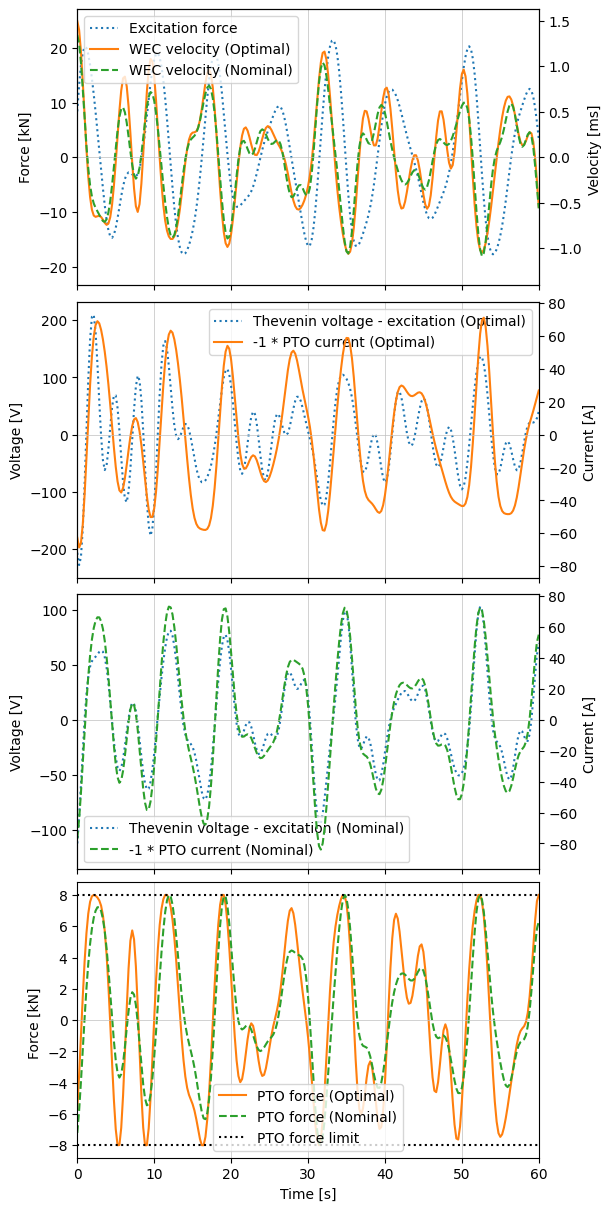

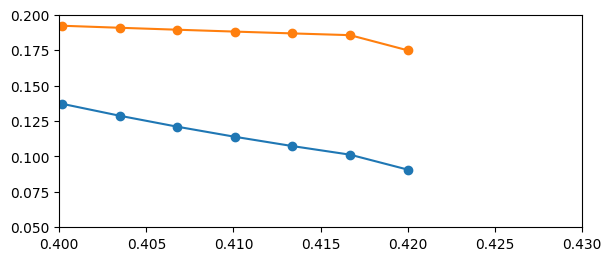

In [5]:
# solve nominal and optimal cases
def var_pto_solve(pto_impedance, scale_x_opt, waves):
    # PTO
    pto = wot.pto.PTO(
        fb.nb_dofs, 
        np.eye(fb.nb_dofs), 
        None, 
        pto_impedance, 
        None, 
        ["PTO_Heave"],
    )
    #     # PTO force constraint constraints
    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
        return f_max - np.abs(f.flatten())
    wec.constraints = [{'type': 'ineq',
                        'fun': const_f_pto,
                        }]
    # WEC additional forces
    wec.forces['PTO'] = pto.force_on_wec
    # objective function
    objective = pto.average_power
    # optimal controller
    results = wec.solve(waves, objective, 2*nfreq, scale_x_opt=scale_x_opt)
    # post-process
    pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)
    results = {
        'results': results,
        'pto_fdom': pto_fdom, 
        'pto_tdom': pto_tdom, 
        'wec_fdom': wec_fdom, 
        'wec_tdom': wec_tdom}
    return results

pto_impedance_optimal = pto_impedance(24, -10)  # OPTIMAL
pto_impedance_nominal = pto_impedance()
optimal_pto_irreg = var_pto_solve(pto_impedance_optimal, 1e-2,  waves[0])
nominal_pto_irreg = var_pto_solve(pto_impedance_nominal, 1e-2,  waves[0])

# theoretical results
time = wec.time_nsubsteps(nsubsteps)
time_xr = xr.DataArray(time)

Fe_nom_irr_A = (nominal_pto_irreg['wec_fdom'].force.sel(type = 'Froude_Krylov') + 
        nominal_pto_irreg['wec_fdom'].force.sel(type = 'diffraction')).sel(influenced_dof = 'DOF_0')
Fe_opt_irr_A = (nominal_pto_irreg['wec_fdom'].force.sel(type = 'Froude_Krylov') + 
        nominal_pto_irreg['wec_fdom'].force.sel(type = 'diffraction')).sel(influenced_dof = 'DOF_0')

V_th_opt, Z_th_opt =  thevenin_equivalent(Zi,pto_impedance_optimal,Fe_opt_irr_A)
V_th_nom, Z_th_nom =  thevenin_equivalent(Zi,pto_impedance_nominal,Fe_nom_irr_A)

v_th_nom_td = wot.time_results(V_th_nom, time_xr)
v_th_opt_td = wot.time_results(V_th_opt, time_xr)
fe_nom_irr_A_td = wot.time_results(Fe_nom_irr_A, time_xr)
fe_opt_irr_A_td = wot.time_results(Fe_opt_irr_A, time_xr)

power_max = np.abs(Fe_nom_irr_A)**2 / (8* np.real(Zi))
epower_nom_max = np.abs(V_th_nom)**2 / (8* np.real(Z_th_nom))
epower_opt_max = np.abs(V_th_opt)**2 / (8* np.real(Z_th_opt))

# Plot
def align_yyaxis(ax1, ax2):
    ax1_ylims = ax1.axes.get_ylim()
    ax1_yratio = ax1_ylims[0] / ax1_ylims[1]
    ax2_ylims = ax2.axes.get_ylim()
    ax2_yratio = ax2_ylims[0] / ax2_ylims[1]
    if ax1_yratio < ax2_yratio: 
        ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
    else:
        ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

# plot
fig, ax = plt.subplots(nrows=4,
                       figsize=(6,12), sharex = True,
                       constrained_layout=True)

line1 = ax[0].plot(time, fe_nom_irr_A_td/1000, ':', label='Excitation force')
ax[0].set_ylabel('Force [kN]')


ax0r = ax[0].twinx()
line2 = ax0r.plot(time, optimal_pto_irreg['wec_tdom'].vel.sel(influenced_dof = 'DOF_0'), 'C1', label = 'WEC velocity (Optimal)')
line3 = ax0r.plot(time, nominal_pto_irreg['wec_tdom'].vel.sel(influenced_dof = 'DOF_0'), 'C2', label = 'WEC velocity (Nominal)', linestyle='--')

ax0r.set_ylabel('Velocity [ms] ')

ax0r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[0],ax0r)
lines = line1 + line2 + line3 
ax0r.legend(lines, ['Excitation force','WEC velocity (Optimal)', 'WEC velocity (Nominal)' ])

plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[0].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')

line1 = ax[1].plot(time, v_th_opt_td, 'C0', linestyle = 'dotted')
ax[1].set_ylabel('Voltage [V]')
ax1r = ax[1].twinx()
line2 = ax1r.plot(time, -1*optimal_pto_irreg['pto_tdom'].trans_flo, 'C1', label = 'WEC velocity (Optimal)')
ax1r.set_ylabel('Current [A] ')
ax1r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[1],ax1r)
lines = line1  + line2
ax[1].legend(lines, ['Thevenin voltage - excitation (Optimal)',
                     '-1 * PTO current (Optimal)'])
plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[1].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')

line1 = ax[2].plot(time, v_th_nom_td, 'C0', linestyle = 'dotted')
ax[2].set_ylabel('Voltage [V]')
ax2r = ax[2].twinx()
line2 = ax2r.plot(time, -1*nominal_pto_irreg['pto_tdom'].trans_flo, 'C2', label = 'PTO current (Nominal)', linestyle='--')
ax2r.set_ylabel('Current [A] ')
ax2r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[2],ax2r)
lines =  line1 +line2 
ax[2].legend(lines, ['Thevenin voltage - excitation (Nominal)',
                     '-1 * PTO current (Nominal)'])
plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[2].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')

line1 = ax[3].plot(time, optimal_pto_irreg['pto_tdom'].force/1000, 'C1', label = 'PTO force (Optimal)')
line2 = ax[3].plot(time, nominal_pto_irreg['pto_tdom'].force/1000, 'C2', label = 'PTO force (Nominal)', linestyle='--')
ax[3].set_ylabel('Force [kN] ')
ax[3].axhline(y=8, linestyle=':', linewidth=1.5, color = 'k')
ax[3].legend(['PTO force (Optimal)', 'PTO force (Nominal)', 'PTO force limit'])
ax[3].axhline(y=-8, linestyle=':', linewidth=1.5, color = 'k')
ax[3].axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')
ax[3].set_xlabel('Time [s]')
ax[3].set_xlim([0, 60])

fig, ax = plt.subplots(figsize=(6,2.5), constrained_layout=True)
ax = [ax,]
ax[0].plot(freq, np.abs(V_th_opt)/np.abs((V_th_opt).max()).squeeze(), label = 'Thevenin voltage (Optimal)', linestyle = '-', marker="o")
ax[0].plot(freq, np.abs(V_th_nom)/np.abs((V_th_nom)).max().squeeze(), label = 'Thevenin voltage (Nominal)', linestyle = '-', marker="o")
ax[0].set_ylabel('')
ax[0].set_ylim(0.05, 0.2)
ax[0].set_title('')
ax[0].set_xlim(left=f1, right=f1*nfreq)
# ax[0].legend(loc = 'upper right')

ax[0].set_xlim([0.4, 0.43])

### DEBUG

In [6]:
fk_o = (nominal_pto_irreg['wec_fdom'].force.sel(type = 'Froude_Krylov')).sel(influenced_dof = 'DOF_0')
dif = (nominal_pto_irreg['wec_fdom'].force.sel(type = 'diffraction')).sel(influenced_dof = 'DOF_0')
ex = fk_o + dif

(0.0, 125.0)

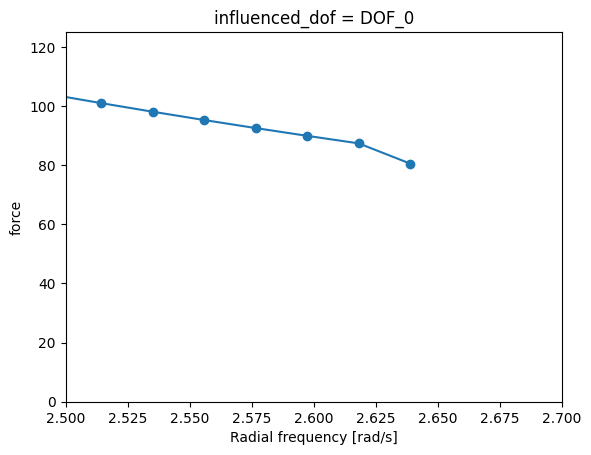

In [7]:
np.abs(ex).plot(marker='o')
plt.xlim([2.5, 2.7])
plt.ylim([0,125])

(120.0, 160.0)

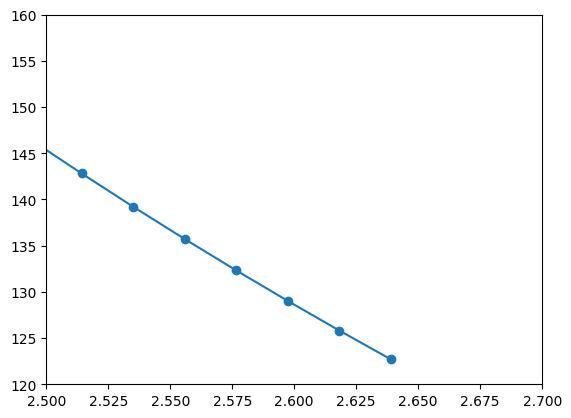

In [8]:
plt.plot(omega, np.abs(fk_o[1:]), marker='o')
plt.xlim([2.5, 2.7])
plt.ylim([120,160])

(2.5, 2.7)

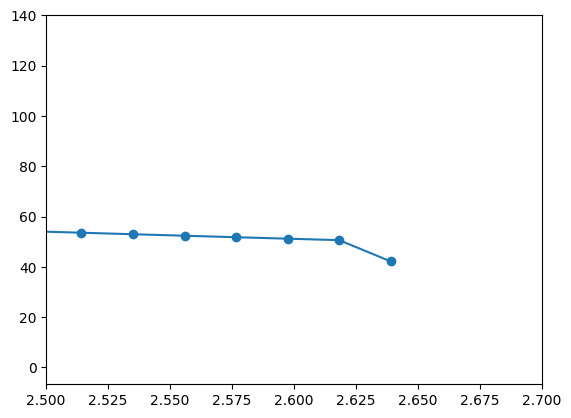

In [9]:
plt.plot(omega, np.abs(dif[1:]), marker='o')
plt.xlim([2.5, 2.7])
# plt.ylim([120,160])

In [10]:
np.abs(ex[-3:])

<xarray.DataArray 'force' (omega: 3)>
array([89.92233119, 87.37691766, 80.53193696])
Coordinates:
  * omega           (omega) float64 2.597 2.618 2.639
    influenced_dof  <U5 'DOF_0'
    freq            (omega) float64 0.4134 0.4167 0.42
    period          (omega) float64 2.419 2.4 2.381

In [11]:
(np.abs(ex[-1])/np.abs(ex[-2])).values, (np.abs(fk_o[-1])/np.abs(fk_o[-2])).values

(array(0.92166145), array(0.97522582))

In [12]:
def rat(v):
    x = v.omega.values
    y = np.abs(v.values)
    dx = x[-2] - x[-3]
    dy = y[-2] - y[-3]
    m = dy/dx
    b = y[-3] - m*x[-3]
    yy = m*x[-1] + b
    print(f"{yy} , {yy/y[-1]} , {y[-1]/yy}")
    return

rat(ex)

84.8315041261232 , 1.0533895908386433 , 0.9493163865458953


In [13]:
rat(fk_o)

122.6120197143328 , 0.9992678602798717 , 1.0007326761414335


In [14]:
rat(dif)

50.029182477930476 , 1.1863713581072153 , 0.842906391128188


In [15]:
1/np.sqrt(2)

0.7071067811865475